In [1]:
print("Acknowledgment:")
print("https://github.com/pritishuplavikar/Face-Recognition-on-Yale-Face-Dataset")

Acknowledgment:
https://github.com/pritishuplavikar/Face-Recognition-on-Yale-Face-Dataset


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import glob
from numpy import linalg as la
import random
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import os

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn
from typing import Tuple, List
from typeguard import typechecked

In [4]:
@typechecked
def qa1_load(folder_path:str) -> Tuple[np.ndarray, np.ndarray]:
	"""
	Returns the dataset (tuple of x, y the label).

	x should be of shape [165, 243 * 320]
	label can be extracted from the subject number in filename. ('subject01' -> '01 as label)
	"""
	data = []
	labels = []
	for file_name in os.listdir(folder_path):
		file_path = os.path.join(folder_path, file_name)
		img_data = np.array(mpimg.imread(file_path)).reshape(-1)
		data.append(img_data)
		label = int(file_name.split("subject")[1][:2])
		labels.append(label)
	return np.array(data), np.array(labels)

In [5]:
@typechecked
def qa2_preprocess(dataset:np.ndarray) -> np.ndarray:
	"""
	returns data (x) after pre processing

	hint: consider using preprocessing.MinMaxScaler
	"""
	scaler = preprocessing.MinMaxScaler()
	n_samples, n_pixels = dataset.shape
	data_2d = dataset.reshape(n_samples, -1)
	data_scaled = scaler.fit_transform(data_2d)
	return data_scaled.reshape(n_samples, n_pixels)

In [6]:
@typechecked
def qa3_calc_eig_val_vec(dataset:np.ndarray, k:int)-> Tuple[PCA, np.ndarray, np.ndarray]:
	"""
	Calculate eig values and eig vectors.
	Use PCA as imported in the code to create an instance
	return them as tuple PCA, eigen_value, eigen_vector
	"""
	pca = PCA(n_components=k)
	pca.fit(dataset)
	eigen_values = pca.explained_variance_
	eigen_vectors = pca.components_
	return pca, eigen_values, eigen_vectors

In [7]:
def qb_plot_written(eig_values:np.ndarray):
	"""
	No structure is required for this question. It does not have to return anything.
	Use this function to produce plots
	"""
	# Compute the total energy
	total_energy = np.sum(eig_values)

	# Compute the energy captured by each principal component
	energy = eig_values / total_energy

	# Compute the cumulative energy captured by the first k principal components
	cum_energy = np.cumsum(energy)

	# Plot the first k eigenvalues
	k = len(eig_values)
	x = np.arange(k) + 1
	plt.plot(x, eig_values, 'bo-', linewidth=1, markersize=2)

	# Compute the number of components needed to capture 50% of the energy
	idx = np.argmax(cum_energy >= 0.5) + 1
	plt.axvline(x=idx, color='red', linestyle='--')
	plt.text(idx + 2, 0.8 * np.max(eig_values), str(idx), color='red', fontsize=14)

	# Add labels and title
	plt.xlabel('Principal component', fontsize=16)
	plt.ylabel('Eigenvalue', fontsize=16)
	plt.title('Eigenvalue spectrum', fontsize=20)

	# Show the plot
	plt.show()

In [8]:
@typechecked
def qc1_reshape_images(pca:PCA, dim_x = 243, dim_y = 320) -> np.ndarray:
	"""
	reshape the pca components into the shape of original image so that it can be visualized
	"""
	num_components = pca.n_components_
	pca_components = pca.components_.reshape(num_components, dim_x, dim_y)
	return pca_components

In [9]:
def qc2_plot(org_dim_eig_faces:np.ndarray):
    """
    No structure is required for this question. It does not have to return anything.
    Use this function to produce plots
    """
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

    for i in range(10):
        row = i // 5
        col = i % 5
        axs[row, col].imshow(org_dim_eig_faces[i], cmap='gray')
        axs[row, col].set_title(f'Eigenface {i+1}')
        axs[row, col].axis('off')

    plt.show()

In [10]:
@typechecked
def qd1_project(dataset:np.ndarray, pca:PCA) -> np.ndarray:
    """
    Return the projection of the dataset 
    NOTE: TO TEST CORRECTNESS, please submit to autograder
    """
    dataset_centered = dataset - pca.mean_
    dataset_projected = np.dot(dataset_centered, pca.components_.T)
    
    return dataset_projected

In [11]:
@typechecked
def qd2_reconstruct(projected_input:np.ndarray, pca:PCA) -> np.ndarray:
    """
    Return the reconstructed image given the pca components
    NOTE: TO TEST CORRECTNESS, please submit to autograder
    """
    dataset_reconstructed = np.dot(projected_input, pca.components_) + pca.mean_
    
    return dataset_reconstructed

In [12]:
def qd3_visualize(dataset:np.ndarray, pca:PCA, dim_x = 243, dim_y = 320):
    """
    No structure is required for this question. It does not have to return anything.
    Use this function to produce plots. You can use other functions that you coded up for the assignment
    """
    # Select a couple of images from the data
    num_images = 2
    image_idxs = np.random.choice(dataset.shape[0], size=num_images, replace=False)
    images = dataset[image_idxs]

    # Define the number of components to use
    num_components = [1, 10, 20, 30, 40, 50]

    # Reconstruct the images using different numbers of components
    reconstructed_images = []
    for k in num_components:
        pca.components_ = pca.components_[:k]
        projected_images = qd1_project(images, pca)
        reconstructed_images.append(qd2_reconstruct(projected_images, pca))

    # Visualize the original images and the reconstructed images
    fig, axs = plt.subplots(nrows=num_images*2, ncols=len(num_components), figsize=(20, 10))
    for i in range(num_images):
        axs[i*2, 0].imshow(images[i].reshape(dim_x, dim_y), cmap='gray')
        axs[i*2, 0].set_title('Original Image')

        for j, k in enumerate(num_components):
            axs[i*2, j].imshow(reconstructed_images[j][i].reshape(dim_x, dim_y), cmap='gray')
            axs[i*2, j].set_title(f'{k} Components')

            axs[i*2+1, j].imshow((images[i] - reconstructed_images[j][i]).reshape(dim_x, dim_y), cmap='gray')
            axs[i*2+1, j].set_title(f'Residual {k} Components')

    plt.tight_layout()
    plt.show()

In [13]:
@typechecked
def qe1_svm(trainX:np.ndarray, trainY:np.ndarray, pca:PCA) -> Tuple[int, float]:
	"""
	Given the data, and PCA components. Select a subset of them in range [1,100]
	Project the dataset and train svm (with 5 fold cross validation) and return
	best_k, and test accuracy (averaged across fold).

	Hint: you can pick 5 `k' values uniformly distributed
	"""
	# Select 5 k values uniformly distributed between 1 and 100
	k_values = np.linspace(1, 100, num=5, dtype=int)

	# Project the training data for each k value
	projected_data = [qd1_project(trainX, pca) for k in k_values]

	# Define the parameter grid for the SVM
	param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

	# Train an SVM with 5-fold cross-validation for each k value
	best_k = 0
	best_acc = 0.0
	for i, k in enumerate(k_values):
		X = projected_data[i]
		y = trainY
		clf = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
		clf.fit(X, y)
		acc = clf.best_score_
		if acc > best_acc:
			best_k = k
			best_acc = acc

	return int(best_k), float(best_acc)

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold


@typechecked
def qe2_lasso(trainX:np.ndarray, trainY:np.ndarray, pca:PCA) -> Tuple[int, float]:
	"""
	Given the data, and PCA components. Select a subset of them in range [1,100]
	Project the dataset and train svm (with 5 fold cross validation) and return
	best_k, and test accuracy (averaged across fold) in that order.

	Hint: you can pick 5 `k' values uniformly distributed
	"""
	kf = KFold(n_splits=5, shuffle=True, random_state=0)
	alphas = np.logspace(-3, 3, 100)
	k_values = np.linspace(1, 100, 5, dtype=int)

	best_score = 0
	best_k = 0
	for k in k_values:
		projected_train = pca.transform(trainX)[:,:k]
		model = LassoCV(alphas=alphas, cv=kf)
		model.fit(projected_train, trainY)
		score = model.score(projected_train, trainY)
		if score > best_score:
			best_score = score
			best_k = k

	return int(best_k), float(best_score)

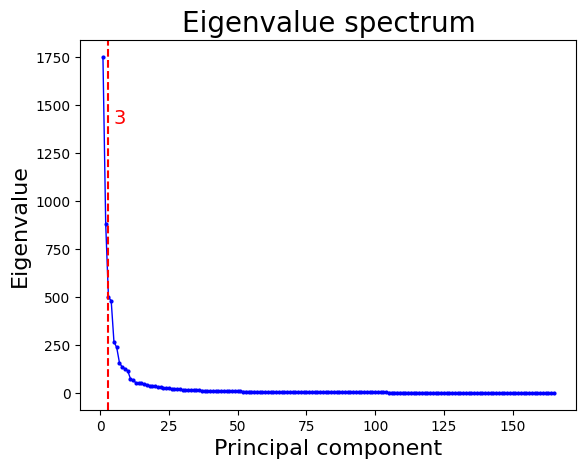

In [15]:
faces, y_target = qa1_load("./data/")
dataset = qa2_preprocess(faces)
pca, eig_values, eig_vectors = qa3_calc_eig_val_vec(dataset, len(dataset))

qb_plot_written(eig_values)

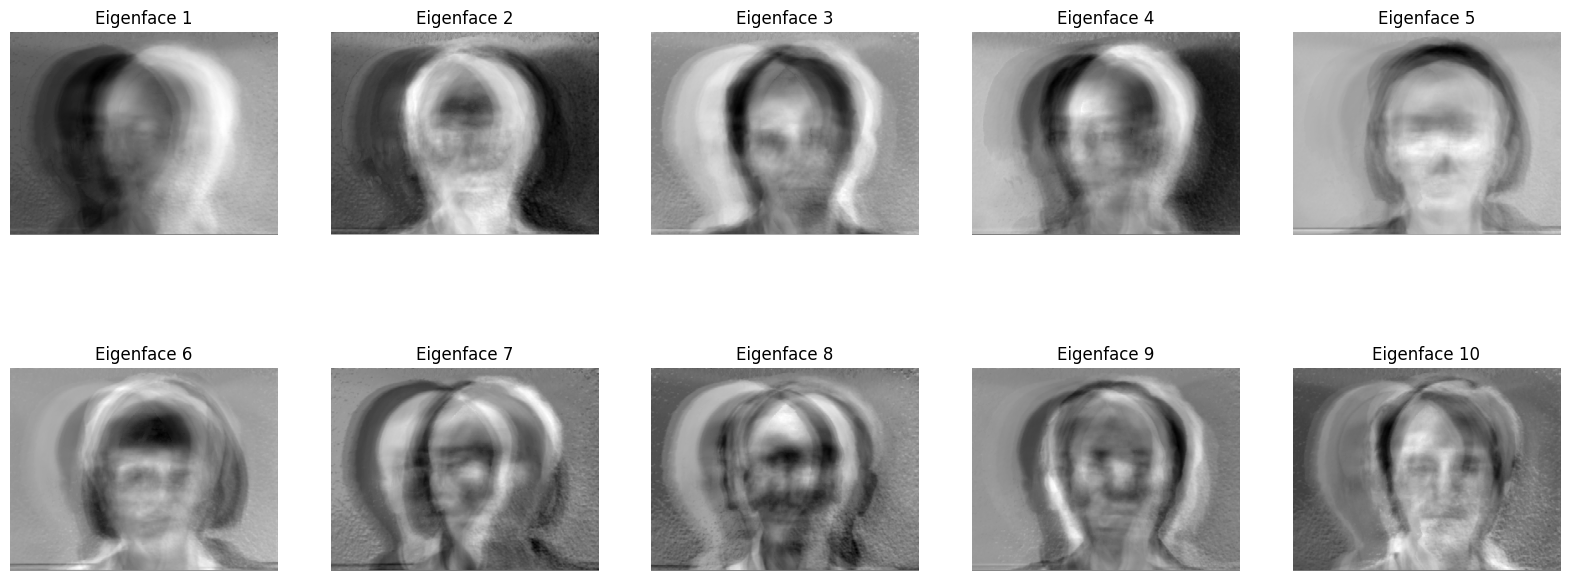

In [16]:
num = len(dataset)
org_dim_eig_faces = qc1_reshape_images(pca)
qc2_plot(org_dim_eig_faces)

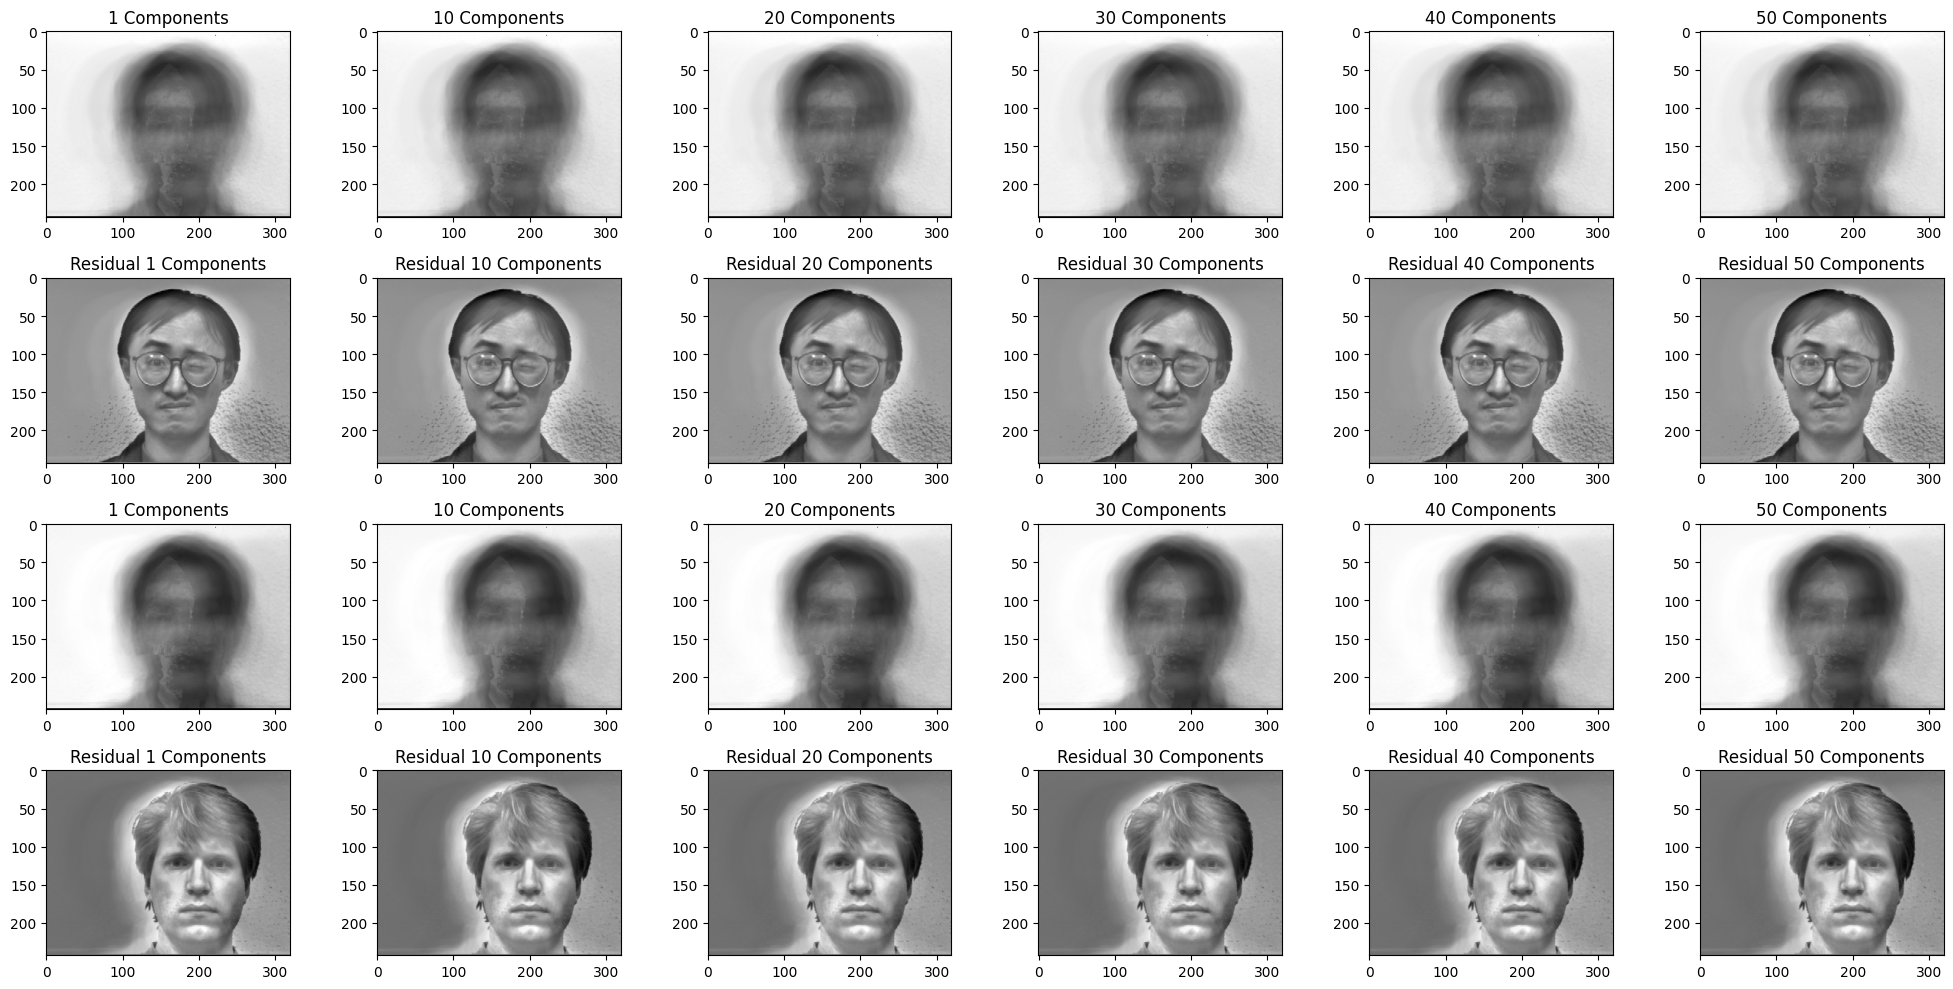

1 0.32727272727272727
1 0.031877453284538504


In [17]:
qd3_visualize(dataset, pca)
best_k, result = qe1_svm(dataset, y_target, pca)
print(best_k, result)
best_k, result = qe2_lasso(dataset, y_target, pca)
print(best_k, result)